In [3]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display

We use a graph data model where nodes represent sequence segments, and edges indicate how multiple segments can be joined together. More specifically, we use a "port graph" in which each node is accessed via ports that correspond to nucleotide positions on the source sequence. This allows pairs of edges to reference subsequences without having to split up existing nodes. The port information is stored on the edges, which specify 'to' and 'from' positions in addition to the source and target node.

The actual sequences are stored in a hash table that may contain metadata on where to find the source sequence (drive, url, ...), but lacks any biological context. Sequence nodes are instantiations of source sequences, they do not have to be unique and are well suited to carry metadata. They are referenced by an identifier that is unique within the graph, which avoids creating ambiguous edges or cycles.

In [4]:
# Create an empty graph
G = nx.DiGraph()

# For the sake of this example, we don't calculate the hash and use a simple dictionary.
sequence_hashes = {'h1': 'ATCGATCGATCG', 
                   'h2': 'CG', 
                   'h3': 'A'}

# Define the starting sequence node via its hash, and use an integer as node identifier for now.
G.add_node(1,  sequence_hash = 'h1')

A sequence variant or edit is represented by edges and sequence nodes, we demonstrate this first for a substitution. In this case we replace the subsequence GAT by CG.

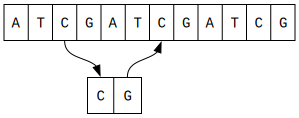

In [5]:
# Add a new sequence node to represent the insert
G.add_node(2, sequence_hash='h2')

# Define port-aware edges by coordinates in the form of: (source node, from position), (target node, to position)
def add_port_edge(graph, source, target):
    # We use edge attributes to store the port information:
    graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

# We add two edges between nodes 1 and 2
add_port_edge(G, (1, 2), (2, 0)) # From node 1, position 2 to node 2, position 0
add_port_edge(G, (2, 1), (1, 6)) # From node 2, position 1 to node 1, position 6

# Let's plot the graph
def draw_port_graph(graph):
    # Create a copy of the graph to avoid modifying the original
    graph = graph.copy()
    
    # Add the actual sequence as node label
    for node in graph.nodes:
        seq = sequence_hashes[graph.nodes[node]['sequence_hash']]
        # Break up the sequence into nucleotides and port markers for graphviz
        label = '|'.join(f'<{i}> {c}' for i, c in enumerate(seq))
        graph.nodes[node]['label'] = label
        # The record node type supports ported nodes
        graph.nodes[node]['shape'] = 'record'
        graph.nodes[node]['fontname'] = 'Courier'

    for edge in graph.edges:
        # Connect the head and tail of each edge to the correct port
        graph.edges[edge]['headport'] = f"{graph.edges[edge]['to_pos']}"
        graph.edges[edge]['tailport'] = f"{graph.edges[edge]['from_pos']}"

    # Convert the networkx graph to a pygraphviz graph
    graph = nx.nx_agraph.to_agraph(graph)

    # Draw the graph using pygraphviz
    fig = SVG(graph.draw(prog='dot', args='-Grankdir=TD ', format='svg'))
    display(fig)

draw_port_graph(G)


We do the same for an insertion after the 7th nucleotide:

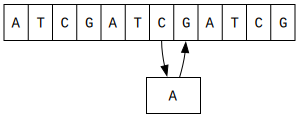

In [6]:
# Restore the same starting sequence
G = nx.DiGraph()
G.add_node(1, sequence_hash = 'h1')

# Add the insert node and two edges
G.add_node(2, sequence_hash='h3')
add_port_edge(G, (1, 6), (2, 0)) # From node 1, position 6 to node 2, position 0
add_port_edge(G, (2, 0), (1, 7)) # From node 2, position 0 to node 2, position 7

draw_port_graph(G)

A deletion is represented by just one edge:

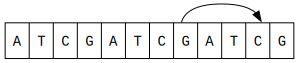

In [7]:
# Restore the same starting sequence
G = nx.DiGraph()
G.add_node(1, sequence_hash = 'h1')

# Delete position 8 to 9
add_port_edge(G, (1, 7), (1, 10)) 

draw_port_graph(G)

In each case, the original source sequence is still present in the graph since we don't break up existing nodes. The advantage of this is that operations are easy to combine as the edges are additive:

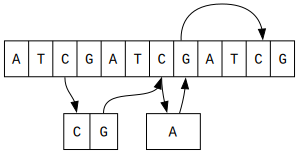

In [8]:
# Starting sequence
G.add_node(1,  sequence_hash = 'h1')

# Substitution
G.add_node(2, sequence_hash='h2')
add_port_edge(G, (1, 2), (2, 0))
add_port_edge(G, (2, 1), (1, 6))

# Insertion
G.add_node(3, sequence_hash='h3')
add_port_edge(G, (1, 6), (3, 0)) 
add_port_edge(G, (3, 0), (1, 7)) 

# Deletion
add_port_edge(G, (1, 7), (1, 10)) 

draw_port_graph(G)

The port graph as described above is an efficient way to represent and combine many operations, but it is less intuitive compared to a pangenome graph where each node is a distinct segment. The latter form is also what graph aware sequence aligners tend to expect. That being said, we can convert a port graph into a segment graph and vice versa without loss of information.

In [23]:
# Create a new graph to store the split nodes
port_graph = G.copy()
segment_graph = nx.DiGraph()

# Iterate over all nodes in the graph and split them into segments
for node in port_graph.nodes:
    # Get ports from incoming and outgoing edges
    in_ports = [data['to_pos'] for source, target, data in port_graph.in_edges(node, data=True)]
    out_ports = [data['from_pos'] for source, target, data in port_graph.out_edges(node, data=True)]

    # Break up the sequence into segments after each out port and before each in port
    break_postions = sorted(set(in_ports + out_ports)) # fix this

    sequence = sequence_hashes[port_graph.nodes[node]['sequence_hash']]

    segments = [sequence[i:j] for i, j in zip([0] + break_postions, break_postions + [None])]
    print(segments)

# Sort all the ports that are used as inputs and outputs, and break up the sequences appropriately (for outputs immediately after the position, for inputs immediately before)

# Create new segment nodes that are addressed by the source segment identifier and a position

# Create edges that represent the reference sequence, label them as such

# Create new edges from the operation edges


['AT', 'CGAT', 'C', 'GAT', 'CG']
['', 'C', 'G']
['', 'A']


In [15]:
port_graph.in_edges(1,data=True)

InEdgeDataView([(1, 1, {'from_pos': 7, 'to_pos': 10}), (2, 1, {'from_pos': 1, 'to_pos': 6}), (3, 1, {'from_pos': 0, 'to_pos': 7})])